# 개선된 U-Net 모델 만들기

## Step 1. KITTI 데이터셋 수집과 구축

- 데이터 출처: http://www.cvlibs.net/datasets/kitti/eval_semantics.php

In [1]:
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [2]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training/'

#### org Image

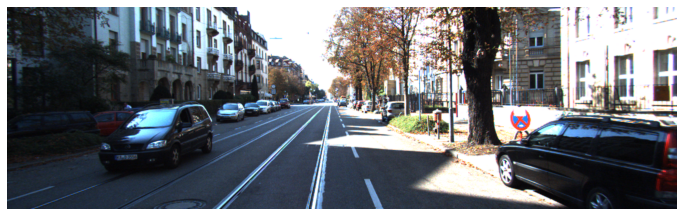

In [3]:
plt.figure(figsize=(12, 6))
image = Image.open(dir_path + 'image_2/000000_10.png').convert("RGB")
plt.imshow(image)
plt.axis('off')
plt.show()

#### instance

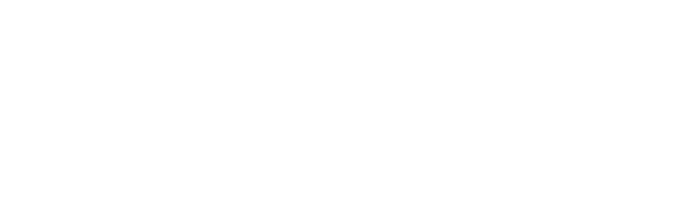

In [4]:
plt.figure(figsize=(12, 6))
image = Image.open(dir_path + 'instance/000000_10.png')
plt.imshow(image)
plt.axis('off')
plt.show()
# 왜 출력안돼ㅜ ㅜ

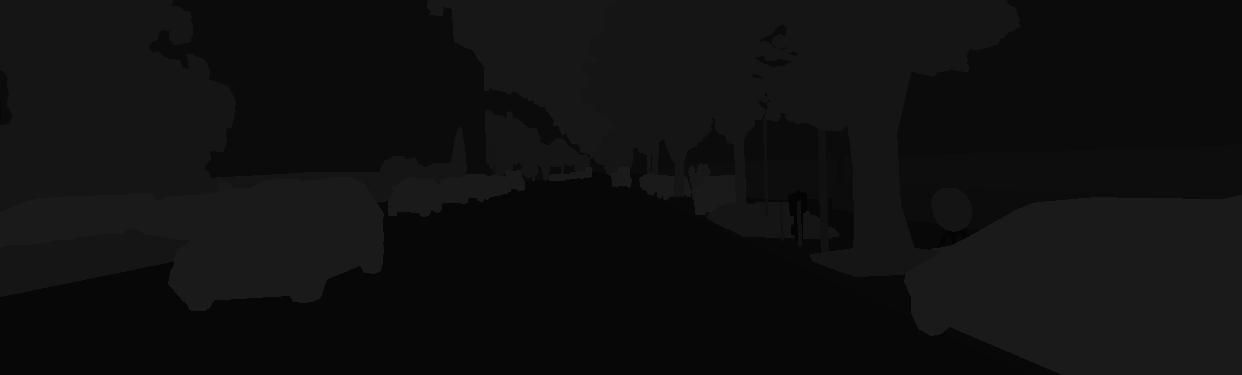

##### semantic

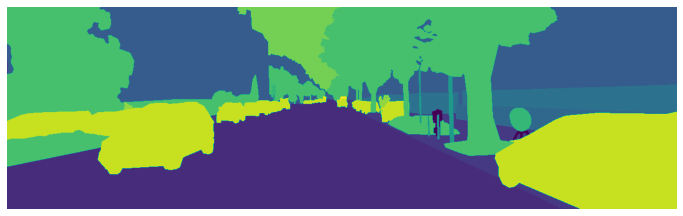

In [5]:
plt.figure(figsize=(12, 6))
image = Image.open(dir_path + 'semantic/000000_10.png')
plt.imshow(image)
plt.axis('off')
plt.show()
# 왜 출력안돼ㅜ ㅜ

#### semantic_rgb

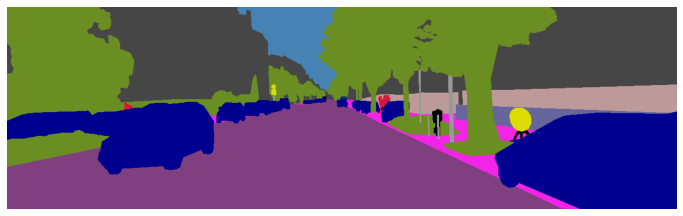

In [6]:
plt.figure(figsize=(12, 6))
image = Image.open(dir_path + 'semantic_rgb/000000_10.png').convert("RGB")
plt.imshow(image)
plt.axis('off')
plt.show()

#### augmentation

In [3]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

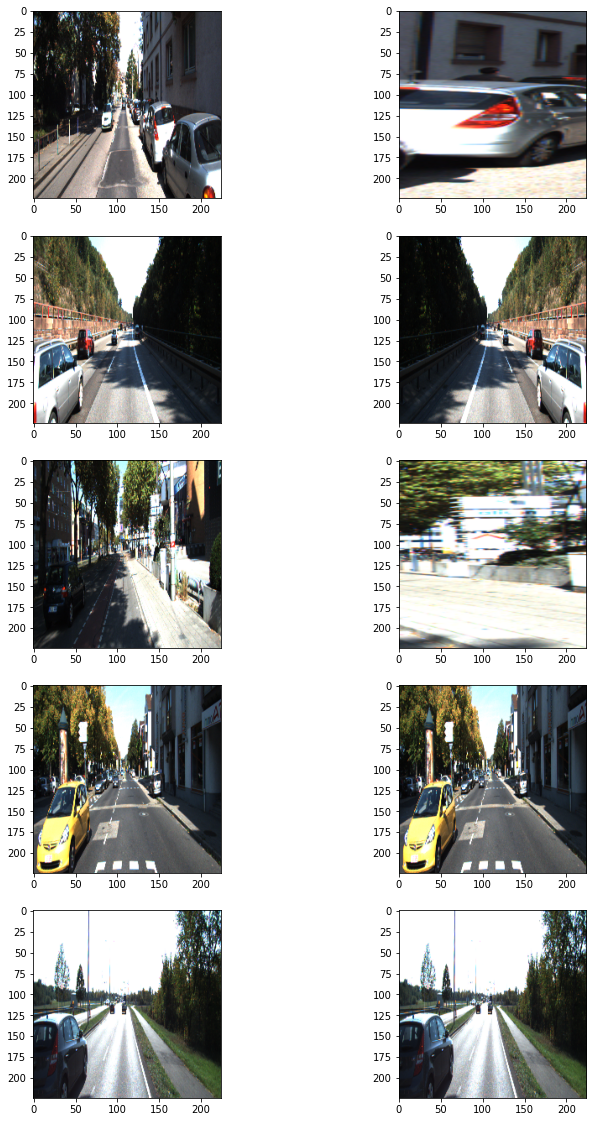

In [4]:
augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [9]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=8,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [10]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

### Step 1 -1 U-Net으로 학습

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

def conv_block(inputs, filters, kernel_size=3, activation='relu'):
    x = Conv2D(filters, kernel_size, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    return x

def build_model(input_shape=(256,256,3), num_classes=2):
    inputs = Input(input_shape)

    # Contracting Path (Encoder)
    conv1 = conv_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(pool3, 512)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = conv_block(pool4, 1024)

    # Expanding Path (Decoder)
    up1 = UpSampling2D(size=(2, 2))(conv5)
    up1 = concatenate([conv4, up1], axis=-1)
    conv6 = conv_block(up1, 512)
    up2 = UpSampling2D(size=(2, 2))(conv6)
    up2 = concatenate([conv3, up2], axis=-1)
    conv7 = conv_block(up2, 256)
    up3 = UpSampling2D(size=(2, 2))(conv7)
    up3 = concatenate([conv2, up3], axis=-1)
    conv8 = conv_block(up3, 128)
    up4 = UpSampling2D(size=(2, 2))(conv8)
    up4 = concatenate([conv1, up4], axis=-1)
    conv9 = conv_block(up4, 64)

    # Output
    if num_classes == 2:
        outputs = Conv2D(1, 1, activation='sigmoid')(conv9)
    else:
        outputs = Conv2D(num_classes, 1, activation='softmax')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# 모델 생성
input_shape = (224, 224, 3)  # 입력 이미지의 형태
num_classes = 2  # 클래스 수 (배경과 전경 등)
model = build_model(input_shape, num_classes)

# 모델 컴파일
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 요약 출력
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [12]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

# model = build_model()
model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
11/11 [==============================] - 24s 794ms/step - loss: 0.4983 - val_loss: 0.6683
Epoch 2/100
11/11 [==============================] - 8s 719ms/step - loss: 0.1108 - val_loss: 0.3845
Epoch 10/100
11/11 [==============================] - 8s 719ms/step - loss: 0.0958 - val_loss: 0.2873
Epoch 11/100
11/11 [==============================] - 8s 723ms/step - loss: 0.0866 - val_loss: 0.2507
Epoch 12/100
11/11 [==============================] - 8s 725ms/step - loss: 0.0890 - val_loss: 0.2251
Epoch 13/100
11/11 [==============================] - 8s 726ms/step - loss: 0.0794 - val_loss: 0.2256
Epoch 14/100
11/11 [==============================] - 8s 726ms/step - loss: 0.0733 - val_loss: 0.1842
Epoch 15/100
11/11 [==============================] - 8s 725ms/step - loss: 0.0691 - val_loss: 0.1605
Epoch 16/100
11/11 [==============================] - 8s 723ms/step - loss: 0.0748 - val_loss: 0.1459
Epoch 17/100
11/11 [==============================] - 8s 723ms/step - loss: 0.0782 

#### Step 1 -2 U-Net 시각화

In [13]:
# model = tf.keras.models.load_model(model_path) # < 학습 진행 안할시

In [15]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [16]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction).sum()
    union = np.logical_or(target, prediction).sum()
    iou_score = float(intersection) / union
#     print('IoU: %f' % iou_score)
    return iou_score

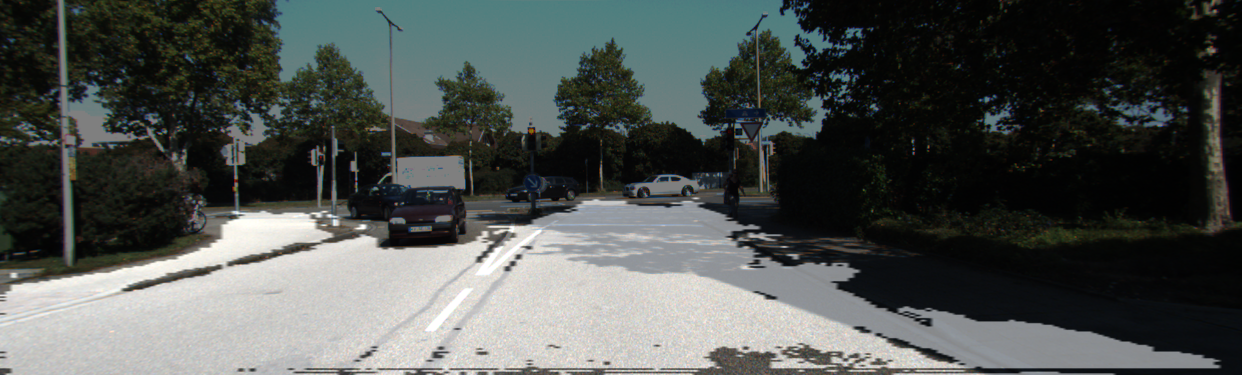

IoU: 0.757580


0.7575798776342624

In [16]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 7    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

## Step 2. U-Net++ 모델의 구현

In [17]:
# import tensorflow as tf
# from tensorflow.keras.layers import *
# from tensorflow.keras.models import Model

# def conv_block(inputs, filters, kernel_size=3, activation='relu'):
#     x = Conv2D(filters, kernel_size, padding='same')(inputs)
#     x = BatchNormalization()(x)
#     x = Activation(activation)(x)
#     x = Conv2D(filters, kernel_size, padding='same')(x)
#     x = BatchNormalization()(x)
#     x = Activation(activation)(x)
#     return x

# def level_block(inputs, filters, depth, activation='relu'):
#     if depth == 0:
#         x = conv_block(inputs, filters, activation=activation)
#         return x

#     x = conv_block(inputs, filters, activation=activation)
#     downsample = MaxPooling2D(2)(x)
#     lower = level_block(downsample, filters * 2, depth - 1, activation=activation)
#     upsample = UpSampling2D(2)(lower)
#     x = concatenate([x, upsample], axis=-1)
#     x = conv_block(x, filters, activation=activation)
#     return x

# def UNetPlusPlus(input_shape, num_classes):
#     inputs = Input(input_shape)

#     # Contracting Path (Encoder)
#     conv1 = conv_block(inputs, 64)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
#     conv2 = conv_block(pool1, 128)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
#     conv3 = conv_block(pool2, 256)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
#     conv4 = conv_block(pool3, 512)
#     pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

#     # Bottleneck
#     conv5 = conv_block(pool4, 1024)

#     # Expanding Path (Decoder)
#     up1 = UpSampling2D(size=(2, 2))(conv5)
#     up1 = concatenate([conv4, up1], axis=-1)
#     conv6 = conv_block(up1, 512)
#     up2 = UpSampling2D(size=(2, 2))(conv6)
#     up2 = concatenate([conv3, up2], axis=-1)
#     conv7 = conv_block(up2, 256)
#     up3 = UpSampling2D(size=(2, 2))(conv7)
#     up3 = concatenate([conv2, up3], axis=-1)
#     conv8 = conv_block(up3, 128)
#     up4 = UpSampling2D(size=(2, 2))(conv8)
#     up4 = concatenate([conv1, up4], axis=-1)
#     conv9 = conv_block(up4, 64)
    
#     # Output
#     if num_classes == 2:
#         outputs = Conv2D(1, 1, activation='sigmoid')(conv9)
#     else:
#         outputs = Conv2D(num_classes, 1, activation='softmax')(conv9)

#     model = Model(inputs=inputs, outputs=outputs)
#     return model

# # 모델 생성
# input_shape = (224, 224, 3)  # 입력 이미지의 형태
# num_classes = 2  # 클래스 수 (배경과 전경 등)
# pp_model = UNetPlusPlus(input_shape, num_classes)

# # 모델 컴파일
# # model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # 모델 요약 출력
# pp_model.summary()

In [18]:
# pp_model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unetpp.h5'

# # pp_model = build_model_UNetpp()
# pp_model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
# pp_model.fit(
#      train_generator,
#      validation_data=test_generator,
#      steps_per_epoch=len(train_generator),
#      epochs=100,
#  )

# pp_model.save(model_path)  #학습한 모델을 저장해 주세요.

In [11]:
def encoder_block(x, fillter_n, max_pooling=False):

    enc = Conv2D(fillter_n, 3, padding='same')(x)

    enc = BatchNormalization()(enc)

    enc = tf.keras.activations.relu(enc)

   

    enc = Conv2D(fillter_n, 3, padding='same')(enc)

    enc = BatchNormalization()(enc)

    enc = tf.keras.activations.relu(enc)


    if max_pooling:

        pool = MaxPooling2D(pool_size=2)(enc)

        return enc, pool

    return enc





def build_unetpp(input_shape=(224, 224, 3)):

    inputs = Input(input_shape)  

    

    # Encoder

    x0_0, px0_0 = encoder_block(inputs, 64, max_pooling=True)

    x1_0, px1_0 = encoder_block(px0_0, 128, max_pooling=True)

    x2_0, px2_0 = encoder_block(px1_0, 256, max_pooling=True)

    x3_0, px3_0 = encoder_block(px2_0, 512, max_pooling=True)

    

    

    # Skip conn

    ux1_0 = UpSampling2D(2)(x1_0)

    cx0_1 = concatenate([x0_0, ux1_0], axis=3)

    x0_1 = encoder_block(cx0_1, 64)

    

    ux2_0 = UpSampling2D(2)(x2_0)

    cx1_1 = concatenate([x1_0, ux2_0], axis=3)

    x1_1 = encoder_block(cx1_1, 128)

    

    ux3_0 = UpSampling2D(2)(x3_0)

    cx2_1 = concatenate([x2_0, ux3_0], axis=3)

    x2_1 = encoder_block(cx2_1, 256)

    

    ux1_1 = UpSampling2D(2)(x1_1)

    cx0_2 = concatenate([x0_0, x0_1, ux1_1], axis=3)

    x0_2 = encoder_block(cx0_2, 64)

    

    ux2_1 = UpSampling2D(2)(x2_1)

    cx1_2 = concatenate([x1_0, x1_1, ux2_1], axis=3)

    x1_2 = encoder_block(cx1_2, 128)

    

    ux1_2 = UpSampling2D(2)(x1_2)

    cx0_3 = concatenate([x0_0, x0_1, x0_2, ux1_2], axis=3)

    x0_3 = encoder_block(cx0_3, 64)

    

    

    x4_0 = encoder_block(px3_0, 1024)

    

    # Decoder

    ux4_0 = UpSampling2D(2)(x4_0)

    cx3_1 = concatenate([x3_0, ux4_0], axis=3)

    x3_1 = encoder_block(cx3_1, 512)

    

    ux3_1 = UpSampling2D(2)(x3_1)

    cx2_2 = concatenate([x2_0, x2_1, ux3_1], axis=3)

    x2_2 = encoder_block(cx2_2, 256)

    

    ux2_2 = UpSampling2D(2)(x2_2)

    cx1_3 = concatenate([x1_0, x1_1, x1_2, ux2_2], axis=3)

    x1_3 = encoder_block(cx1_3, 128)

   

    ux1_3 = UpSampling2D(2)(x1_3)

    cx0_4 = concatenate([x0_0, x0_1, x0_2, x0_3, ux1_3], axis=3)

    x0_4 = encoder_block(cx0_4, 128)

    

    

    output1 = Conv2D(1, 1, padding='same', activation='sigmoid')(x0_1)

    output2 = Conv2D(1, 1, padding='same', activation='sigmoid')(x0_2)

    output3 = Conv2D(1, 1, padding='same', activation='sigmoid')(x0_3)

    output4 = Conv2D(1, 1, padding='same', activation='sigmoid')(x0_4)

    outputs = (output1 + output2 + output3 + output4) / 4

           

    model = tf.keras.Model(inputs=inputs, outputs=outputs) 

    return model
pp_model = build_unetpp()

# 모델 컴파일
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 요약 출력
pp_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 224, 224, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_30 (BatchNo (None, 224, 224, 64) 256         conv2d_34[0][0]                  
__________________________________________________________________________________________________
tf.nn.relu_30 (TFOpLambda)      (None, 224, 224, 64) 0           batch_normalization_30[0][0]     
____________________________________________________________________________________________

In [12]:
pp_model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unetpp2.h5'

# pp_model = build_model_UNetpp()
pp_model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
pp_model.fit(
     train_generator,
    batch_size=8,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

pp_model.save(pp_model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
22/22 [==============================] - 46s 1s/step - loss: 0.4158 - val_loss: 0.6027
Epoch 2/100
22/22 [==============================] - 27s 1s/step - loss: 0.2777 - val_loss: 0.5043
Epoch 3/100
22/22 [==============================] - 27s 1s/step - loss: 0.2069 - val_loss: 0.4209
Epoch 4/100
22/22 [==============================] - 27s 1s/step - loss: 0.1777 - val_loss: 0.3249
Epoch 5/100
22/22 [==============================] - 27s 1s/step - loss: 0.1575 - val_loss: 0.2830
Epoch 6/100
22/22 [==============================] - 27s 1s/step - loss: 0.1474 - val_loss: 0.2439
Epoch 7/100
22/22 [==============================] - 27s 1s/step - loss: 0.1364 - val_loss: 0.2139
Epoch 8/100
22/22 [==============================] - 27s 1s/step - loss: 0.1252 - val_loss: 0.1909
Epoch 9/100
22/22 [==============================] - 27s 1s/step - loss: 0.1179 - val_loss: 0.1652
Epoch 10/100
22/22 [==============================] - 27s 1s/step - loss: 0.1187 - val_loss: 0.1480
Epoch 11/

22/22 [==============================] - 27s 1s/step - loss: 0.0320 - val_loss: 0.0457
Epoch 85/100
22/22 [==============================] - 27s 1s/step - loss: 0.0302 - val_loss: 0.0326
Epoch 86/100
22/22 [==============================] - 27s 1s/step - loss: 0.0303 - val_loss: 0.0444
Epoch 87/100
22/22 [==============================] - 27s 1s/step - loss: 0.0252 - val_loss: 0.0346
Epoch 88/100
22/22 [==============================] - 27s 1s/step - loss: 0.0300 - val_loss: 0.0608
Epoch 89/100
22/22 [==============================] - 27s 1s/step - loss: 0.0326 - val_loss: 0.0318
Epoch 90/100
22/22 [==============================] - 27s 1s/step - loss: 0.0329 - val_loss: 0.0284
Epoch 91/100
22/22 [==============================] - 27s 1s/step - loss: 0.0255 - val_loss: 0.0269
Epoch 92/100
22/22 [==============================] - 27s 1s/step - loss: 0.0262 - val_loss: 0.0302
Epoch 93/100
22/22 [==============================] - 27s 1s/step - loss: 0.0238 - val_loss: 0.0503
Epoch 94/100


NameError: name 'model_path' is not defined

In [13]:
pp_model.save(pp_model_path)  #학습한 모델을 저장해 주세요.

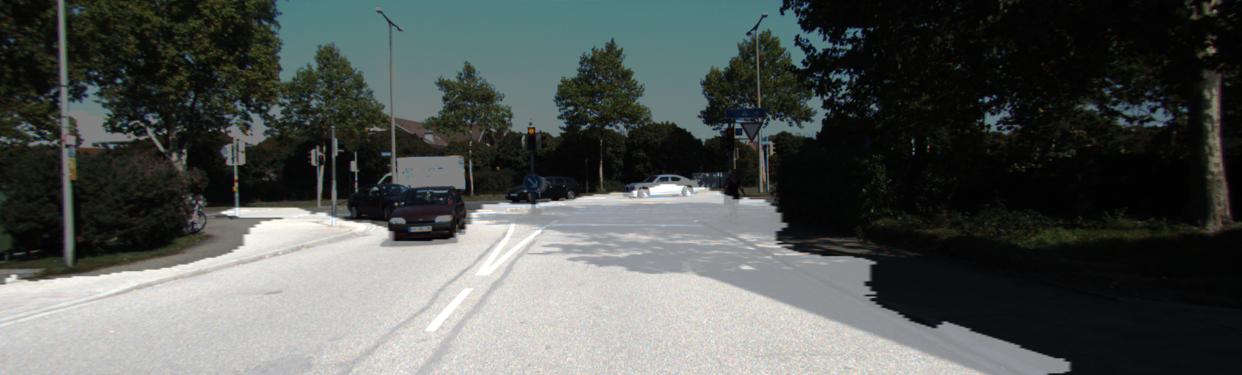

IoU: 0.854050


0.8540496094285323

In [17]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 7    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     pp_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./pp_result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

## Step 3. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석

In [18]:
def get_iou(unet, unetpp, preproc, image_path, label_path, view_on):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = unet(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5) # 이미지 합성
    
    data_pp = {"image":origin_img}
    processed = preproc(**data_pp)
    outputpp = unetpp(np.expand_dims(processed["image"]/255,axis=0))
    outputpp = (outputpp[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction_pp = outputpp/255   # 도로로 판단한 영역
    
    outputpp = Image.fromarray(outputpp)
    background = Image.fromarray(origin_img).convert('RGBA')
    outputpp = outputpp.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    outputpp = Image.blend(background, outputpp, alpha=0.5) # 이미지 합성
    if view_on:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8)) # 2 x 1 이미지 틀 생성
        ax1.imshow(output) # img 설정
        ax1.axis('off') # 축 제거
        ax1.set_title('unet') # title 설정

        ax2.imshow(outputpp) # img 설정
        ax2.axis('off') # 축 제거
        ax2.set_title('unet++') # title 설정

        plt.tight_layout()
        plt.show()
        
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역
        unet_iou = calculate_iou_score(target, prediction)
        unetpp_iou = calculate_iou_score(target, prediction_pp)
        
        return unet_iou, unetpp_iou
    else:
        return _, _

In [19]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'
model = tf.keras.models.load_model(model_path) # < 학습 진행 안할시

In [20]:
# import random
# test_dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/testing/image_2/'
# test_folder = os.listdir(test_dir_path)
# view_array = [False] * len(test_folder)  # test_folder의 image수 만큼을 False로 초기화한 배열#

# # 12개의 요소를 랜덤하게 True로 설정
# random_indices = random.sample(range(len(view_array)), 12)
# view_array = [True if i in random_indices else False for i in range(len(view_array))]

# for i, image_name in enumerate(test_folder):
#     _, _ = get_iou(
#     model,
#     pp_model,
#     test_preproc,
#     image_path=test_dir_path + image_name,
#     label_path=False,
#     view_on=view_array[i]
#     )

IoU: 0.911767
IoU: 0.908888
IoU: 0.902288
IoU: 0.798099
IoU: 0.611965
IoU: 0.559128
IoU: 0.581170
IoU: 0.578573
IoU: 0.642945
IoU: 0.594069
IoU: 0.708885
IoU: 0.534723
IoU: 0.651454
IoU: 0.498512
IoU: 0.757580
IoU: 0.854050


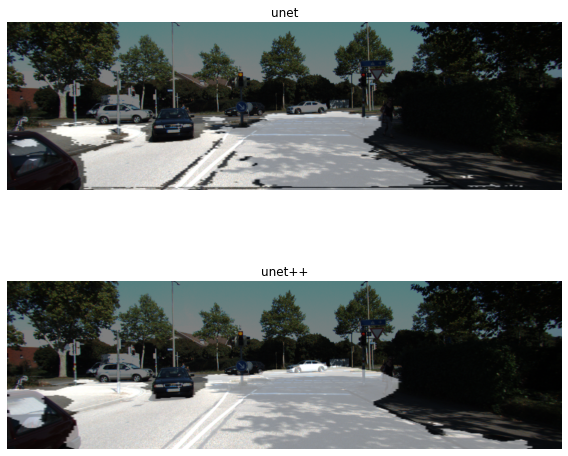

IoU: 0.772584
IoU: 0.753294
IoU: 0.759524
IoU: 0.759630
IoU: 0.753794
IoU: 0.724140
IoU: 0.736446
IoU: 0.706999
IoU: 0.698576
IoU: 0.665031
IoU: 0.845387
IoU: 0.860328


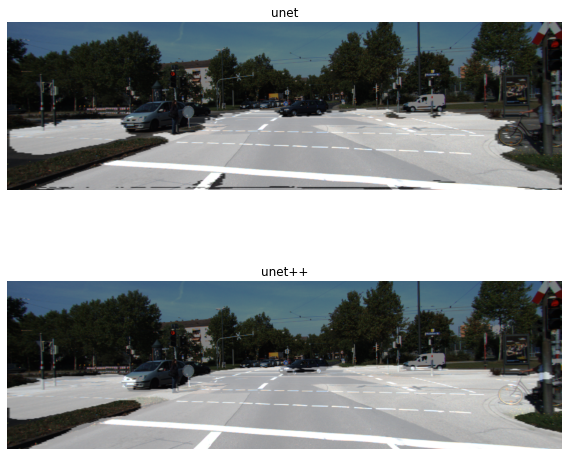

IoU: 0.869842
IoU: 0.853692


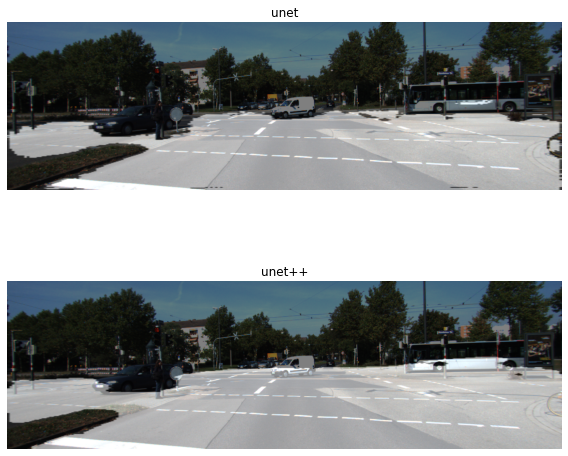

IoU: 0.871109
IoU: 0.835379
IoU: 0.878014
IoU: 0.857572
IoU: 0.876984
IoU: 0.855381
IoU: 0.639170
IoU: 0.842465
IoU: 0.746748
IoU: 0.865122
IoU: 0.719512
IoU: 0.816380
IoU: 0.386155
IoU: 0.680588
IoU: 0.874648
IoU: 0.851830
IoU: 0.854916
IoU: 0.847763
IoU: 0.640105
IoU: 0.668050
IoU: 0.594492
IoU: 0.573151
IoU: 0.571747
IoU: 0.558100
IoU: 0.780522
IoU: 0.788835
IoU: 0.798807
IoU: 0.837961


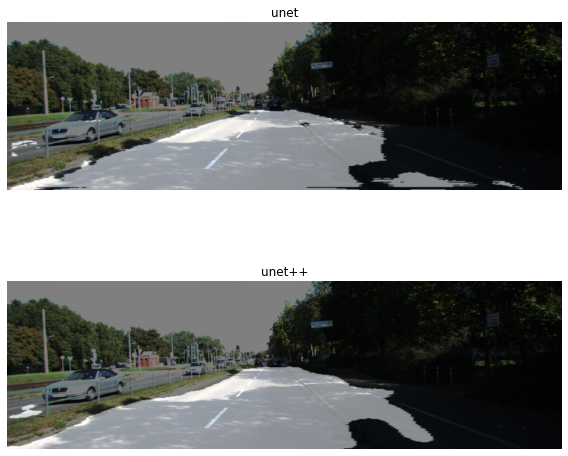

IoU: 0.732690
IoU: 0.728305
IoU: 0.697713
IoU: 0.722769
IoU: 0.722802
IoU: 0.690589
IoU: 0.780299
IoU: 0.810285


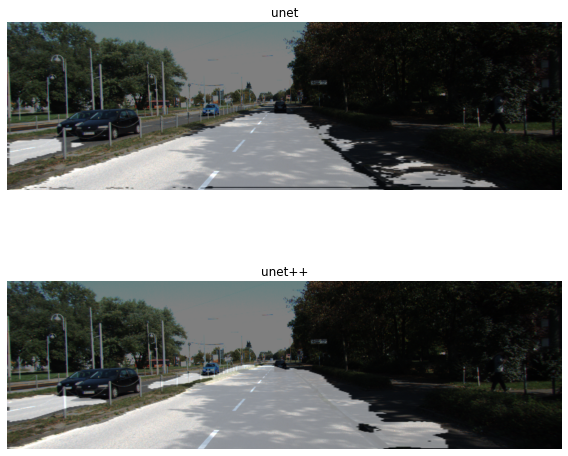

IoU: 0.782142
IoU: 0.779010
IoU: 0.572919
IoU: 0.565482
IoU: 0.814526
IoU: 0.904922
IoU: 0.789881
IoU: 0.930015
IoU: 0.777185
IoU: 0.887461


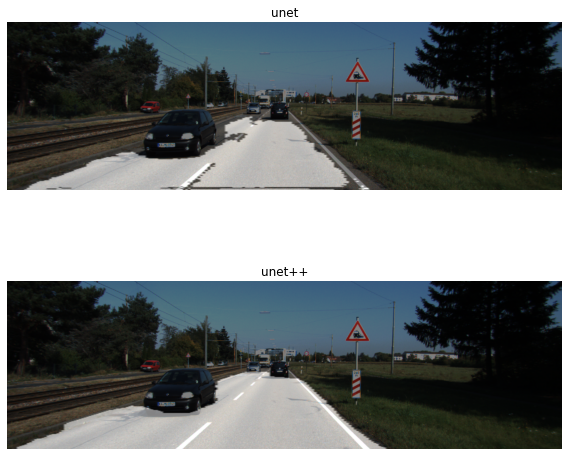

IoU: 0.746890
IoU: 0.891739


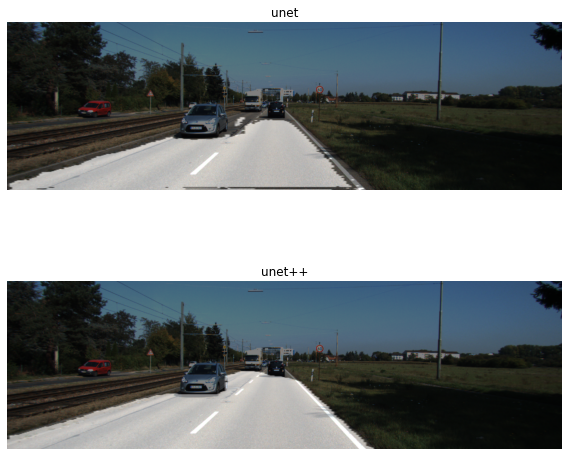

IoU: 0.769976
IoU: 0.921319


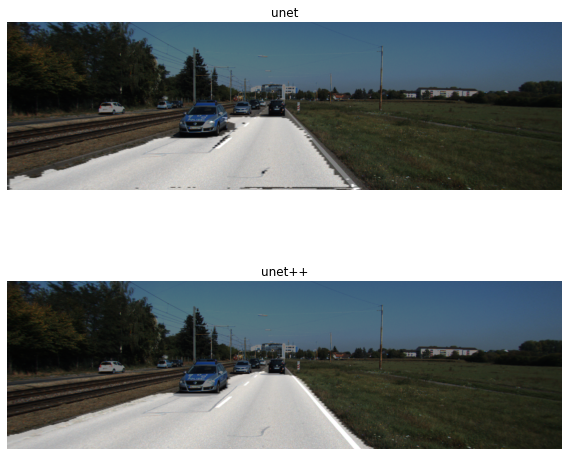

IoU: 0.816939
IoU: 0.938842
IoU: 0.822885
IoU: 0.922438
IoU: 0.788638
IoU: 0.913504
IoU: 0.785794
IoU: 0.821198
IoU: 0.793360
IoU: 0.826995
IoU: 0.789455
IoU: 0.856021
IoU: 0.797176
IoU: 0.828417


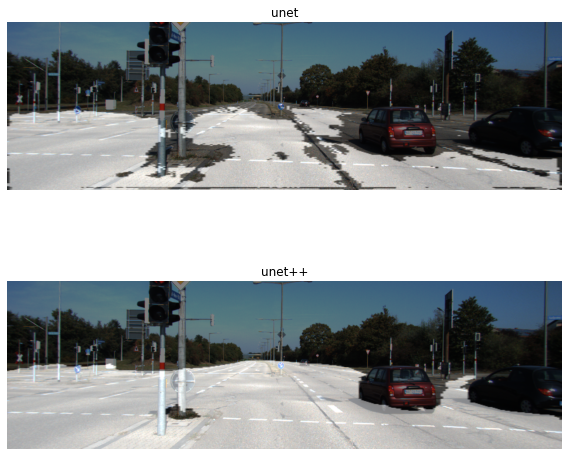

IoU: 0.720957
IoU: 0.824097
IoU: 0.691113
IoU: 0.821786
IoU: 0.621900
IoU: 0.681112
IoU: 0.746337
IoU: 0.815073
IoU: 0.701377
IoU: 0.818606
IoU: 0.735684
IoU: 0.815861
IoU: 0.801116
IoU: 0.841079
IoU: 0.386723
IoU: 0.709193
IoU: 0.561465
IoU: 0.715498


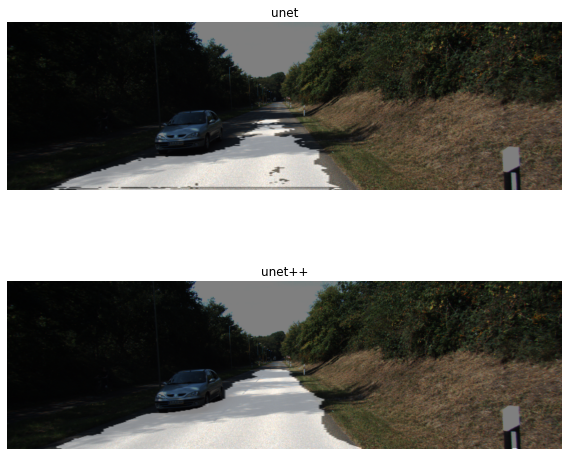

IoU: 0.689807
IoU: 0.866358


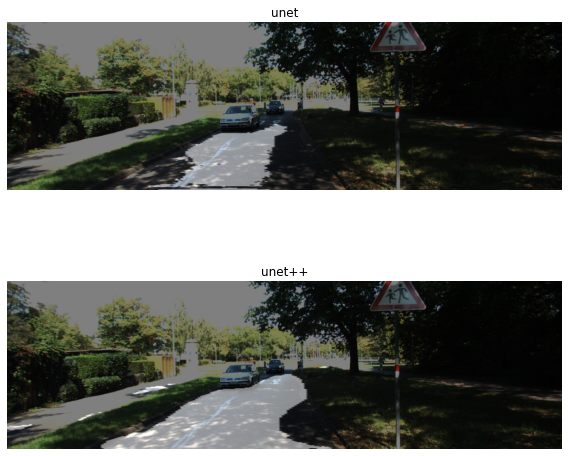

IoU: 0.430375
IoU: 0.752346


In [ ]:
unet_ioues = []
unetpp_ioues = []


train_folder = dir_path + '/image_2/'

import random
view_array = [False] * len(train_folder)  # test_folder의 image수 만큼을 False로 초기화한 배열#

# 12개의 요소를 랜덤하게 True로 설정
random_indices = random.sample(range(len(view_array)), 12)
view_array = [True if i in random_indices else False for i in range(len(view_array))]

for i, _ in enumerate(os.listdir(train_folder)):
    unet_iou, unetpp_iou = get_iou(
        model,
        pp_model,
        test_preproc,
        image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
        label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png',
        view_on=view_array[i]
     )
    unet_ioues.append(unet_iou)
    unetpp_ioues.append(unetpp_iou)


In [30]:
def calculate_ap(iou_list, iou_threshold=0.5):
    # True Positive(TP) 및 False Positive(FP) 초기화
    tp = [0] * len(iou_list)
    fp = [0] * len(iou_list)

    # 실제 상자 수
    num_gt_boxes = len(iou_list)

    # 각 예측 상자에 대한 IoU 계산
    for i, iou in enumerate(iou_list):
        if iou >= iou_threshold:
            tp[i] = 1
        else:
            fp[i] = 1

    # Precision과 Recall 계산
    cumulative_tp = np.cumsum(tp)
    cumulative_fp = np.cumsum(fp)
    precision = cumulative_tp / (cumulative_tp + cumulative_fp)
    recall = cumulative_tp / num_gt_boxes

    # AP50 계산
    ap = 0
    for t in np.arange(0, 1.1, 0.1):
        if np.sum(recall >= t) == 0:
            p = 0
        else:
            p = np.max(precision[recall >= t])
        ap += p / 11

    return ap

In [31]:
unet_ap_50 = calculate_ap(unet_ioues, iou_threshold=0.5)
unet_ap_50

0.8974836080099238

In [32]:
unet_ap_70 = calculate_ap(unet_ioues, iou_threshold=0.7)
unet_ap_70

0.49915824915824913

In [33]:
unet_ap_90 = calculate_ap(unet_ioues, iou_threshold=0.9)
unet_ap_90

0.09090909090909091

In [34]:
unetpp_ap_50 = calculate_ap(unetpp_ioues, iou_threshold=0.5)
unetpp_ap_50

0.8969696969696968

In [35]:
unetpp_ap_70 = calculate_ap(unetpp_ioues, iou_threshold=0.7)
unetpp_ap_70

0.5893939393939394

In [36]:
unetpp_ap_90 = calculate_ap(unetpp_ioues, iou_threshold=0.9)
unetpp_ap_90

0.10570824524312897

|Net|AP50|AP70|AP90|
|---|----|----|----|
|Unet|0.897|0.499|0.090|
|Unet++|0.897|0.589|0.106|

Unet이 AP50에서 조금 더 좋았지만, 
그 외는 Unet++가 더 좋습니다.